# Financial Econometrics: Empirical Analysis #1

### Setup environement
Install yahoo finance API to collect stocks data

In [1]:
#!pip install yfinance
#!pip install fredapi

In [2]:
# basic libs
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# stats libs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox


# import yahoo finance to collect stocks data
import yfinance as yf
from fredapi import Fred

import warnings
warnings.filterwarnings("ignore")

## Import Data

Regarding the period we chose the following period: from 2012-12-31 to 2022-12-31.

We chose to use the FRED API to download to dowload the inflation rate financial time series (`T10YIE`). 

Then we chose to use the Yahoo Finance API to collect stocks data from the FedEx company and oil market prices. FedEx Corporation is an American company and airline specializing in international freight transport. The ticker is of the stocks market FedEx company is`FDX` and the ticker of the oil stocks makret is (`CL=F`).

Our objective is to analyze the impact of oil prices and inflation on the market price of an international logistics/freight transport company whose main raw material is oil.

In summary we have 2 stocks prices time series (Oil and FedEx company) and one macroeconomic time series (inflation rate)

In [3]:
start_date = "2012-12-31"
end_date = "2022-12-31"
tickers = ["FDX", "CL=F"]

# Get data from Yahoo Finance
def get_YF_series(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data


# Get data from FRED :
def get_FRED_series(ticker):
    FRED_API_KEY = "9a54ab68d82273ea59014b16364b5bdd"
    fred = Fred(api_key=FRED_API_KEY)
    data = fred.get_series(ticker)
    data = data.dropna()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    return data

df_stocks = get_YF_series(tickers, start_date, end_date)

df_inflation_rate = get_FRED_series("T10YIE")


df_series=pd.merge(df_stocks,df_inflation_rate, how='inner', left_index=True, right_index=True)
df_series = df_series.rename(columns={0:"inflation_rate"})
df_series

[*********************100%%**********************]  2 of 2 completed


,CL=F,FDX,inflation_rate
2012-12-31,91.820000,81.141151,2.45
2013-01-02,93.120003,83.379311,2.48
2013-01-03,92.919998,83.688911,2.46
2013-01-04,93.089996,83.963188,2.48
2013-01-07,93.190002,83.795097,2.52
...,...,...,...
2022-12-23,79.559998,173.121033,2.20
2022-12-27,79.529999,174.223160,2.26
2022-12-28,78.959999,170.287018,2.28
2022-12-29,78.400002,172.747116,2.27


### Plotting the time series with daily frequency

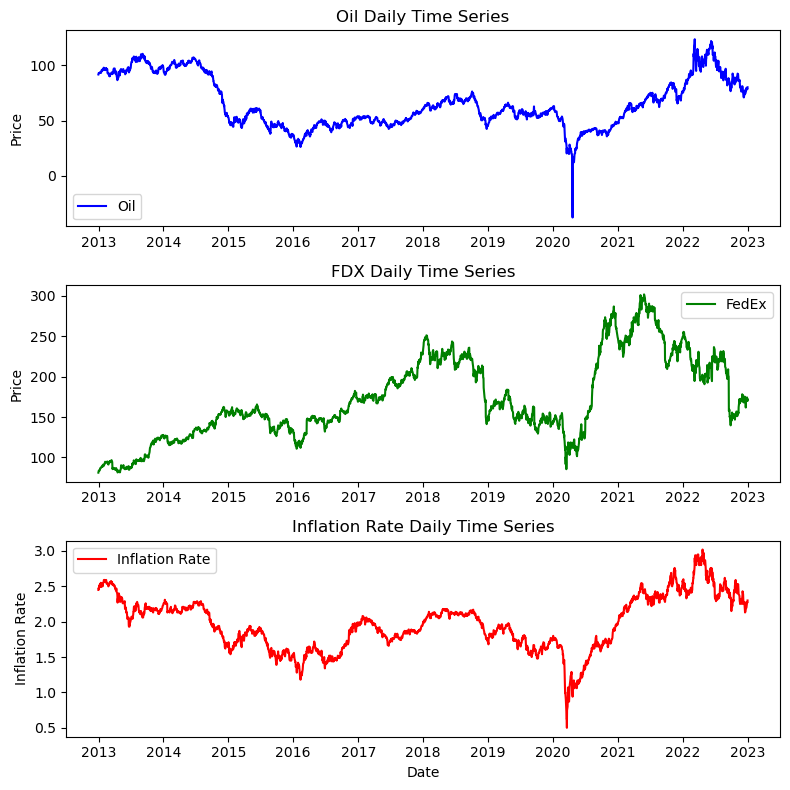

In [4]:
# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Plot resampled time series on each subplot
ax1.plot(df_series.index, df_series['CL=F'], linestyle='-', color='b', label='Oil')
ax1.set_title('Oil Daily Time Series')
ax1.set_ylabel('Price')
ax1.legend()

ax2.plot(df_series.index, df_series['FDX'], linestyle='-', color='g', label='FedEx')
ax2.set_title('FDX Daily Time Series')
ax2.set_ylabel('Price')
ax2.legend()

ax3.plot(df_series.index, df_series['inflation_rate'], linestyle='-', color='r', label='Inflation Rate')
ax3.set_title('Inflation Rate Daily Time Series')
ax3.set_xlabel('Date')
ax3.set_ylabel('Inflation Rate')
ax3.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

We can see firstly that the Inflation Rate and Oil price are very correlated

### Tranform the time series into `log`

In [5]:
df_series_log = np.log(df_series)
df_series_log.isna().any()



CL=F               True
FDX               False
inflation_rate    False
dtype: bool

We have `NaN` value(s) for the `CL=F` series. We we fill NaN value by the previous value. 

In [6]:
# Fill NaN with the previous value
df_series_log['CL=F'].fillna(method='ffill', inplace=True)

In [7]:
df_series_log

,CL=F,FDX,inflation_rate
2012-12-31,4.519830,4.396190,0.896088
2013-01-02,4.533889,4.423400,0.908259
2013-01-03,4.531739,4.427106,0.900161
2013-01-04,4.533567,4.430378,0.908259
2013-01-07,4.534640,4.428375,0.924259
...,...,...,...
2022-12-23,4.376511,5.153991,0.788457
2022-12-27,4.376134,5.160337,0.815365
2022-12-28,4.368941,5.137485,0.824175
2022-12-29,4.361824,5.151829,0.819780


### Plotting the three time series after the log transformation

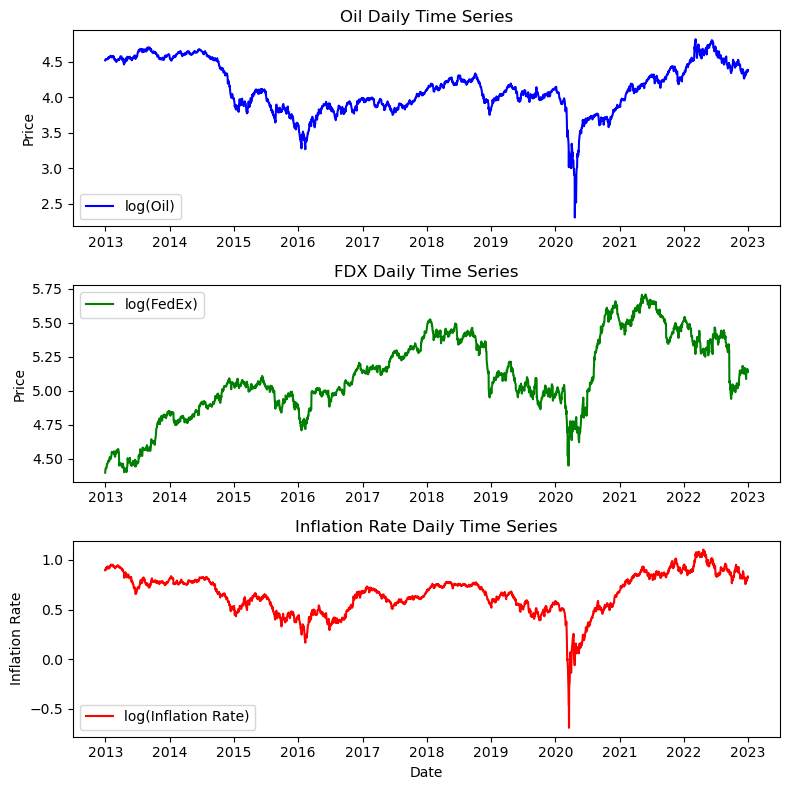

In [8]:
# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Plot resampled time series on each subplot
ax1.plot(df_series_log.index, df_series_log['CL=F'], linestyle='-', color='b', label='log(Oil)')
ax1.set_title('Oil Daily Time Series')
ax1.set_ylabel('Price')
ax1.legend()

ax2.plot(df_series_log.index, df_series_log['FDX'], linestyle='-', color='g', label='log(FedEx)')
ax2.set_title('FDX Daily Time Series')
ax2.set_ylabel('Price')
ax2.legend()

ax3.plot(df_series_log.index, df_series_log['inflation_rate'], linestyle='-', color='r', label='log(Inflation Rate)')
ax3.set_title('Inflation Rate Daily Time Series')
ax3.set_xlabel('Date')
ax3.set_ylabel('Inflation Rate')
ax3.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

After log transformation, we can visually see that the time series appear to follow a stochastic process. Time series appear to follow a stochastic process. They seem to follow random fluctuations, irregular patterns and no clear trend or seasonality. The data therefore appear erratic and may suggest a stochastic process.

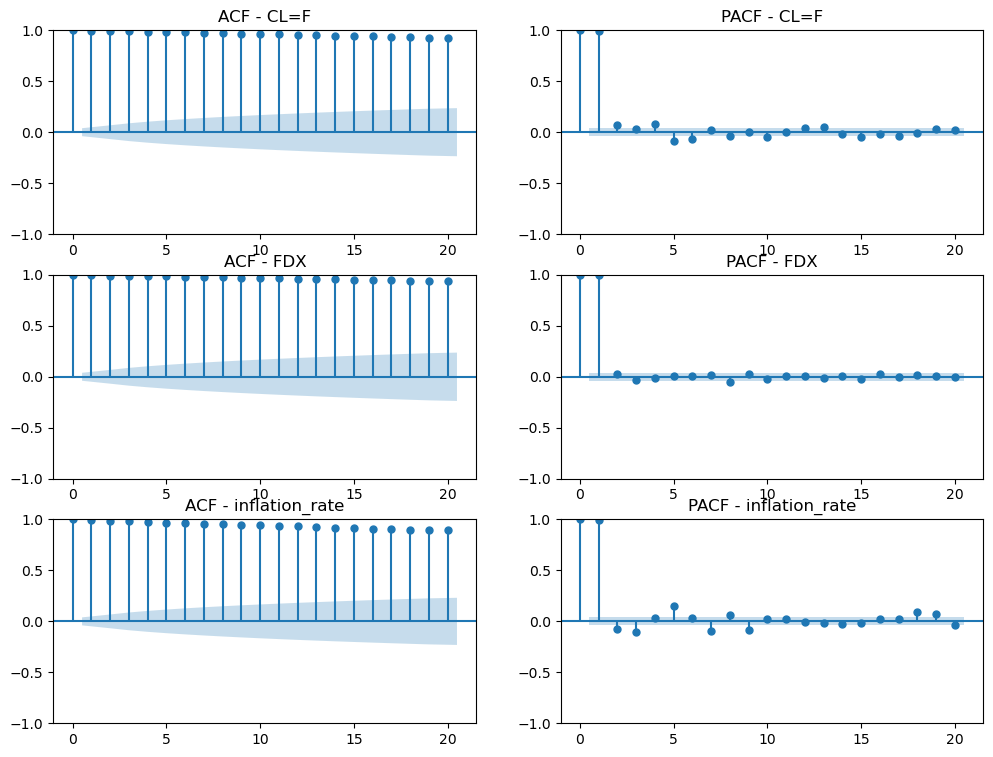

In [9]:
# Plot ACF and PACF for each time series
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))

for i, col in enumerate(df_series_log.columns):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    # Plot ACF
    plot_acf(df_series_log[col], lags=20, ax=ax1)
    ax1.set_title(f'ACF - {col}')

    # Plot PACF
    plot_pacf(df_series_log[col], lags=20, ax=ax2)
    ax2.set_title(f'PACF - {col}')

We can see that the ACF values are close to 1 at lags 1 to 20. This indicate a very strong positive correlation between the current value and the previous 20 values. In other words, the time series is highly correlated with its recent past. This suggests a strong memory or persistence in the data. In fact, the ACF values are high and decrease very, very slowly, this is a sign that the data are not stationary, so they need to be differentiated. But before to take the first difference we will perform a ADF test to test the presence of an unit root for each time series

### Perform a ADF test

We well perform an ADF test in order to test the presence of an unit root for each series.

To do so we consider the following hypothesis in the right order:


$\Delta X_t = b_0 + \rho X_{t-1} + \sum_{j=1}^{p-1} \phi_j \delta X_{t-j}+\epsilon_t$

**REGRESSION: CONSTANT AND TREND**
By performing this test, we assummes that the time series has a deterministic constant offset and a linear trend

Test for deterministic trend:
* $H_0:$ The trend coefficient is not signiciant ($b_1=0$)
* $H_1:$ The trend coefficient is signiciant ($b_1 \neq 0$)

If $H_0$ is rejected we accept $H1$ and check the presence of unit root
Test for unit root with trend:
* $H_0$: There is a unit root (i.e. $\rho \neq 0$ non stationarity) with a significant trend. The time series is non-stationary with deterministic trend.
* $H_1$: There is no unit root (i.e. $\rho = 0$ stationarity) no stochastic trend but a determistic trend.

If $H_0$ don't rejected ($b_1$ is not signicant) we have to turn the regression with constant (without trend)

**REGRESSION: CONSTANT**
By performing this test, we assummes that the time series has a deterministic constant offset but does not consider any trend.

Test for constant:
* $H_0:$ The constant coefficient is not significant ($b_0 = 0$)
* $H_1:$ The constant coefficient is significant ($b_0 \neq 0$)

If $H_0$ is rejected, we accept $H_1$ (i.e $b_0$ is significant $b_0 \neq 0$) and test the presence of unit root with constant:

* $H_0$: There is a unit root (i.e. $\rho \neq 0$ non stationarity) with a significant constant. The series is a random walk with a drift
* $H_1$: There is no unit root (i.e. $\rho = 0$ stationarity) and no sginificant constant

If $H_0$ don't rejected (i.e $b_0$ is not significant $b_0 = 0$) we have to turn the third regression with no constant and no trend and test direclty if the presence of a unit root.

**REGRESSION: NO CONSTANT AND NO TREND**
By performing this test, we assummes that the time series does not have a deterministic constant offset or trend components.

* $H_0$: There is a unit root (i.e. non stationarity). The series is a random walk
* $H_1$: There is no unit root (i.e. stationarity)

The p-value is the probability to wrongly reject $H_0$

If the p-value are lower than the threshold 5%, hence we can reject the null hypothesis $H_0$ and accept $H_1$ and affirm that the time series is likely stationary

Otherwise we fail to reject the null hypothesis $H_0$ and don't accept $H_1$ and affirm that the time series may be non-stationary

In [10]:
def adf_test(series):
    """
    ADFULLER Parameter
    -'c' : constant only (default) (random-walk with a drift)
    -'ct' : constant and trend. (both series could have been trend stationary)
    -'ctt' : constant, and linear and quadratic trend.
    -'n' : no constant, no trend (random walk)
    For example:
    - imposing 'n' to regression mean that we assume a random walk
    - imposing 'c' means you assume a random walk with a drift
    """
    print("______________________________")
    print("REGRESSION : CONSTANT AND TREND")
    print("______________________________")
          
    adf_ct_result = adfuller(series, regression = "ct")       
    
    adf_statistic_ct = adf_ct_result[0]
    p_value_ct = adf_ct_result[1]
    critical_values = adf_ct_result[4]
    
    print(f'ADF Statistic: {adf_statistic_ct}')
    print(f'p-value for the trend: {p_value_ct}')
    print("")
    
    if p_value_ct <= 0.05:
        print("Trend coefficient is sginificatif " + str(p_value_ct) + " < 0.05")
        print("We reject H0 (The trend coefficient is not signiciant (𝑏1=0) and accept H1 (𝑏0≠0)")
        if adf_statistic_ct < critical_values['5%']:
            print("ADF test with Constant and Trend: adf_statistic=" + str(adf_statistic_ct) + " <" + str(critical_values['5%']) + " Reject the null hypothesis H0, we accept H1 at 95% confidence level.") 
            print("The time series is likely stationary but a determistic trend")
            return
        else:
            print("ADF test with Constant and Trend: p-adf_statistic=" + str(adf_statistic_ct) + " >" + str(critical_values['5%']) + " Fail to reject the null hypothesis H0 we can't accept H1 at 95% confidence level.") 
            print("The time series may be non-stationary. There is a presence of a unit root and deterministic trend.")
            print("The time series is non-stationary with trend")
            return
    else:
        print("Trend coefficient is not sginificatif " + str(p_value_ct) + " > 0.05")
        print("We fail to reject H0 (The trend coefficient is not signiciant (𝑏1=0)")
        print("We turn to the second REGRESSION WITH CONSTANT")
          
    
    print("\n______________________________")
    print("REGRESSION : CONSTANT")
    print("______________________________") 
          
    adf_c_result = adfuller(series, regression = "c")
    # Extract ADF test statistics and p-value
    p_value_c = adf_c_result[1]
    critical_values = adf_c_result[4]
    adf_statistic = adf_c_result[0]
                  
    print(f'ADF Statistic: {adf_statistic}')              
    print(f'p-value for the constant: {p_value_c}')
                  
    if p_value_c <= 0.05:
        print('The constant coefficient is significant (𝑏0≠0)')
        print("ADF test with Constant: p-value=" + str(p_value_c) + " < 0.05. Reject the null hypothesis H0, we accept H1 at 95% confidence level.") 
        print("The constant coefficient is not significant")
        if adf_statistic < critical_values['5%']:
            print("ADF test with Constant: adf_statistic=" + str(adf_statistic) + " <" + str(critical_values['5%']) +" Reject the null hypothesis H0, we accept H1 at 95% confidence level.") 
            print("The time series is stationary with a constant")
            return
        else:
            print("ADF test with Constant: adf_statistic=" + str(adf_statistic) + " >" + str(critical_values['5%']) + " Fail to reject the null hypothesis H0 we can't accept H1 at 95% confidence level.") 
            print("The time series may be non-stationary. There is a presence of a unit root and significant constant.")
            print("The series is a random walk with a drift (i.e constant)")
            return
    else:
        print('The constant coefficient is not significant (𝑏0=0)')
        print("ADF test with Constant: p-value=" + str(p_value_c) + " > 0.05.")
        print("We fail to reject the null hypothesis H0 (b0=0)") 
        print("We turn to the third REGRESSION WITH NO CONSTANT AND NO TREND and test the presence of UR")

    print("\n______________________________")
    print("REGRESSION : NO CONSTANT AND NO TREND")
    print("______________________________") 
          
    adf_n_result = adfuller(series, regression = "n")
    # Extract ADF test statistics and p-value
    p_value_n = adf_n_result[1]
                  
    if p_value_c <= 0.05:
        print("ADF test with No Constant and No Trend: p-value=" + str(p_value_n) + " < 0.05. Reject the null hypothesis H0, we accept H1 at 95% confidence level.")
        print("The time series is likely stationary without trend and constant.")
    else:
        print("ADF test with No Constant and No Trend: p-value=" + str(p_value_n) + " > 0.05. Fail to reject the null hypothesis H0, we can't accept H1 at 95% confidence level.")
        print("The time series may be non-stationary. There is a presence of a unit root and stochastic trend.")
        print("The time series is a random walk without constant and deterministic trend")
        
print("###########################################")
print("ADF TEST: OIL SROCK PRICES  (log(CL=F))")
print("###########################################\n")
adf_test(df_series_log['CL=F'])

print("\n\n###########################################")
print("ADF TEST: FedEx STOCK PRICES (log(FXD)) ")
print("###########################################\n") 
adf_test(df_series_log['FDX'])

print("\n\n###########################################")
print("ADF TEST: INFLATION RATE (log(inflation_rate)) ")
print("###########################################\n") 
adf_test(df_series_log['inflation_rate'])
     

###########################################
ADF TEST: OIL SROCK PRICES  (log(CL=F))
###########################################

______________________________
REGRESSION : CONSTANT AND TREND
______________________________
ADF Statistic: -2.4569387154315274
p-value for the trend: 0.3498148230685654

Trend coefficient is not sginificatif 0.3498148230685654 > 0.05
We fail to reject H0 (The trend coefficient is not signiciant (𝑏1=0)
We turn to the second REGRESSION WITH CONSTANT

______________________________
REGRESSION : CONSTANT
______________________________
ADF Statistic: -2.5342535929265395
p-value for the constant: 0.10736090751335386
The constant coefficient is not significant (𝑏0=0)
ADF test with Constant: p-value=0.10736090751335386 > 0.05.
We fail to reject the null hypothesis H0 (b0=0)
We turn to the third REGRESSION WITH NO CONSTANT AND NO TREND and test the presence of UR

______________________________
REGRESSION : NO CONSTANT AND NO TREND
______________________________
ADF

#### Interpretation
For our 2 first regression tests {CONSTANT AND TREND, CONSTANT} we can se that for the 3 time series we fail to reject the null hypothesis H0 and then we can't accept H1 at 95% confidence level. Therefore, we apply the third regression test (NO CONSTANT AND NO TREND) and we can affirm that for the 3 series may be non-stationary without constant and determistic trend. There is a presence of a unit root and stochastic trend. Overall, our 3 series are a random walk without constant and deterministic trend.

We can deduce that we have to to take the first difference for each time series and check if the presence of a unit root (i.e. stochastic trend) again thanks to ADF test.

### Decompose the series

### Times series decomposition

We will decompose each series separately and analyze the different components.

The time series can be decompose with the following 3 components:

$x(t) = Tend + Seasonality + Residual$

**Trend:**
The trend component represents the long-term, systematic, and often nonlinear movement in the data over time. It captures the underlying direction in the time series, whether it's increasing, decreasing, or remaining relatively constant. Trends can be caused by various factors, such as economic growth, population changes, or technological advancements. A time series with a clear trend component may exhibit a consistent upward or downward movement, which is not related to short-term fluctuations or seasonality.

**Seasonality:**
Seasonality refers to the regular, repeating patterns in the data that occur at fixed intervals. These intervals can be daily, weekly, monthly, quarterly, or any other specific time frame. Seasonality is often associated with external factors, such as the calendar (e.g., holidays), weather, or cultural events. Time series with seasonality will show periodic patterns that repeat within a particular time frame.

**Residuals:**
The residual component, also known as the irregular component, represents the unexplained or random variation in the time series that cannot be attributed to the trend or seasonality. It includes noise, unexpected events, and other random factors. Residuals are essentially what remains after removing the trend and seasonality components. Analyzing the residuals is important because they contain valuable information about the inherent uncertainty and unpredictability in the data.

To decompose the series we choose the following period  = 252.

In [11]:
def serie_decompositon(serie, n_period = 252):
    """
    n_period : number of date in a period
        Ex 252 for daily obs, 4 for quarterly, ...
    """
    
    decomposition = seasonal_decompose(serie, period = n_period)
    decomposition.plot()
    plt.show()
    
    trend = pd.DataFrame(decomposition.trend)
    seasonal = pd.DataFrame(decomposition.seasonal)
    residuals = pd.DataFrame(decomposition.resid)
    print("------------------------")
    print("Are the Residuals a WN ?")
    print("------------------------")
    adf = adfuller(serie, regression = "n")
    if adf[0] < adf[4]['5%']:
        print("Residuals is a WN")
    else :
        print("Residuals is NOT a WN")
    concat = pd.concat([serie, trend, seasonal, residuals], axis=1)
    concat.columns = ['initial', 'trend', 'seasonal', 'residuals']   
 
    return concat    

#### Decomposition of Oil stock market time series (before first difference)

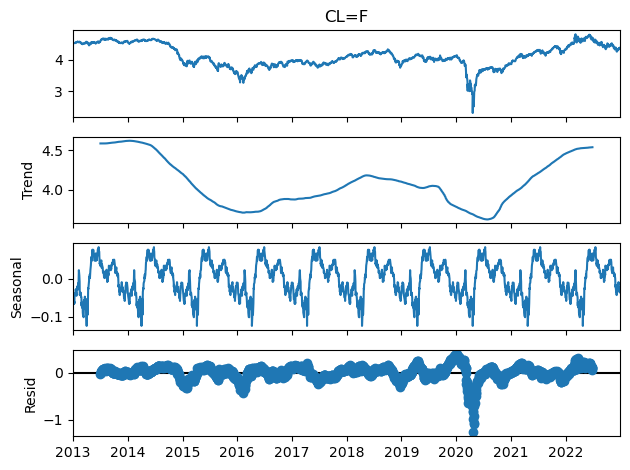

------------------------
Are the Residuals a WN ?
------------------------
Residuals is NOT a WN


,initial,trend,seasonal,residuals
2012-12-31,4.519830,NaN,-0.044612,NaN
2013-01-02,4.533889,NaN,-0.053949,NaN
2013-01-03,4.531739,NaN,-0.055724,NaN
2013-01-04,4.533567,NaN,-0.062543,NaN
2013-01-07,4.534640,NaN,-0.065647,NaN
...,...,...,...,...
2022-12-23,4.376511,NaN,-0.021106,NaN
2022-12-27,4.376134,NaN,-0.021950,NaN
2022-12-28,4.368941,NaN,-0.028284,NaN
2022-12-29,4.361824,NaN,-0.030031,NaN


In [12]:
serie_decompositon(df_series_log['CL=F'])

#### Decomposition of FedEx stock market time series (before first difference)

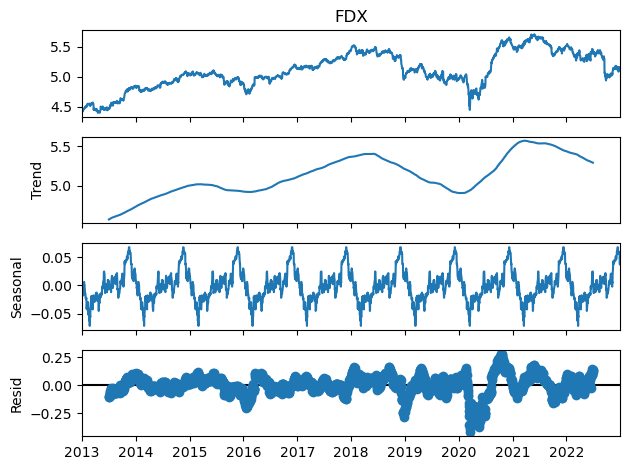

------------------------
Are the Residuals a WN ?
------------------------
Residuals is NOT a WN


,initial,trend,seasonal,residuals
2012-12-31,4.396190,NaN,0.004440,NaN
2013-01-02,4.423400,NaN,0.004527,NaN
2013-01-03,4.427106,NaN,-0.004927,NaN
2013-01-04,4.430378,NaN,-0.003370,NaN
2013-01-07,4.428375,NaN,-0.006194,NaN
...,...,...,...,...
2022-12-23,5.153991,NaN,0.057938,NaN
2022-12-27,5.160337,NaN,0.056200,NaN
2022-12-28,5.137485,NaN,0.038725,NaN
2022-12-29,5.151829,NaN,0.037194,NaN


In [13]:
serie_decompositon(df_series_log['FDX'])

#### Decomposition of  stock market time series (before first difference)

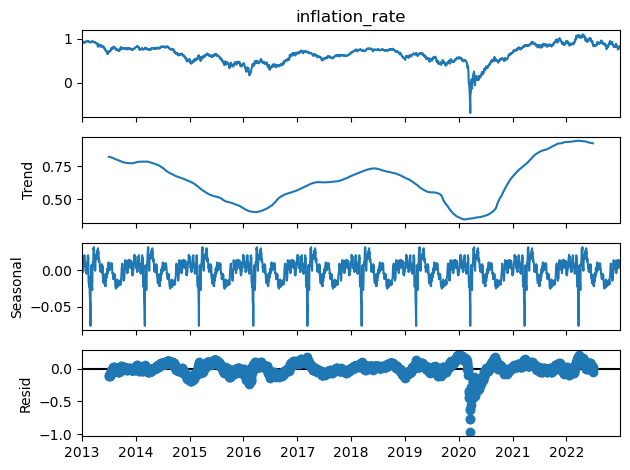

------------------------
Are the Residuals a WN ?
------------------------
Residuals is NOT a WN


,initial,trend,seasonal,residuals
2012-12-31,0.896088,NaN,0.004190,NaN
2013-01-02,0.908259,NaN,0.005209,NaN
2013-01-03,0.900161,NaN,0.004445,NaN
2013-01-04,0.908259,NaN,0.003597,NaN
2013-01-07,0.924259,NaN,-0.002431,NaN
...,...,...,...,...
2022-12-23,0.788457,NaN,0.012636,NaN
2022-12-27,0.815365,NaN,0.012208,NaN
2022-12-28,0.824175,NaN,0.011810,NaN
2022-12-29,0.819780,NaN,0.012447,NaN


In [14]:
serie_decompositon(df_series_log['inflation_rate'])

### Taking the first difference

We will take the first difference for each time series and check that there is no more stochastic trend.

In [15]:
df_series_log_diff = df_series_log.diff().dropna()
df_series_log_diff

,CL=F,FDX,inflation_rate
2013-01-02,0.014059,0.027210,0.012171
2013-01-03,-0.002150,0.003706,-0.008097
2013-01-04,0.001828,0.003272,0.008097
2013-01-07,0.001074,-0.002004,0.016000
2013-01-08,-0.000429,0.004109,-0.011976
...,...,...,...
2022-12-23,0.026363,0.001365,0.004556
2022-12-27,-0.000377,0.006346,0.026907
2022-12-28,-0.007193,-0.022852,0.008811
2022-12-29,-0.007117,0.014343,-0.004396


### Plot the first difference of each serie

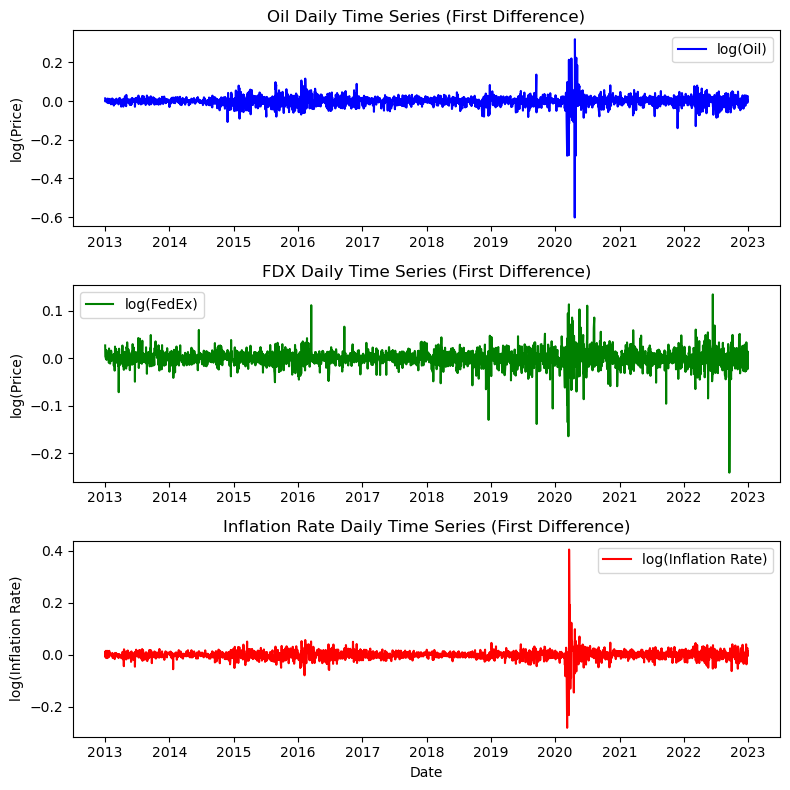

In [16]:
# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

# Plot resampled time series on each subplot
ax1.plot(df_series_log_diff.index, df_series_log_diff['CL=F'], linestyle='-', color='b', label='log(Oil)')
ax1.set_title('Oil Daily Time Series (First Difference)')
ax1.set_ylabel('log(Price)')
ax1.legend()

ax2.plot(df_series_log_diff.index, df_series_log_diff['FDX'], linestyle='-', color='g', label='log(FedEx)')
ax2.set_title('FDX Daily Time Series (First Difference)')
ax2.set_ylabel('log(Price)')
ax2.legend()

ax3.plot(df_series_log_diff.index, df_series_log_diff['inflation_rate'], linestyle='-', color='r', label='log(Inflation Rate)')
ax3.set_title('Inflation Rate Daily Time Series (First Difference)')
ax3.set_xlabel('Date')
ax3.set_ylabel('log(Inflation Rate)')
ax3.legend()

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

We can see visualy that the series seems to be now stationary after taking the first difference. We will perform a ADF to check is that there are no more stochastic trend.

### Perform ADF test on each series after taking first difference

In [17]:
print("###########################################")
print("ADF TEST (First difference): OIL SROCK PRICES  (log(CL=F))")
print("###########################################\n")
adf_test(df_series_log_diff['CL=F'])

print("\n\n###########################################")
print("ADF TEST (First difference): FedEx STOCK PRICES (log(FXD)) ")
print("###########################################\n") 
adf_test(df_series_log_diff['FDX'])

print("\n\n###########################################")
print("ADF TEST (First difference): INFLATION RATE (log(inflation_rate)) ")
print("###########################################\n") 
adf_test(df_series_log_diff['inflation_rate'])

###########################################
ADF TEST (First difference): OIL SROCK PRICES  (log(CL=F))
###########################################

______________________________
REGRESSION : CONSTANT AND TREND
______________________________
ADF Statistic: -9.104015740103508
p-value for the trend: 2.1147474425019912e-13

Trend coefficient is sginificatif 2.1147474425019912e-13 < 0.05
We reject H0 (The trend coefficient is not signiciant (𝑏1=0) and accept H1 (𝑏0≠0)
ADF test with Constant and Trend: adf_statistic=-9.104015740103508 <-3.4122646594651993 Reject the null hypothesis H0, we accept H1 at 95% confidence level.
The time series is likely stationary but a determistic trend


###########################################
ADF TEST (First difference): FedEx STOCK PRICES (log(FXD)) 
###########################################

______________________________
REGRESSION : CONSTANT AND TREND
______________________________
ADF Statistic: -15.871767305534206
p-value for the trend: 1.16383119

#### Interpretation
According the ADF test, we can se that after applying first difference, the 3 time series are stationary but a determistic trend. Therefore, we affirm that for the 3 series are likely stationary. There is no presence of a unit root and stochastic trend.

### Decompose the series (after taking first difference)

To decompose the series we choose the following period  = 252.

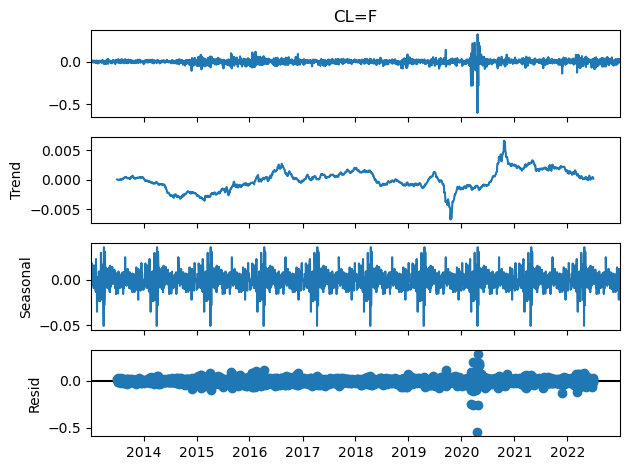

------------------------
Are the Residuals a WN ?
------------------------
Residuals is a WN


,initial,trend,seasonal,residuals
2013-01-02,0.014059,NaN,-0.009396,NaN
2013-01-03,-0.002150,NaN,-0.001833,NaN
2013-01-04,0.001828,NaN,-0.006879,NaN
2013-01-07,0.001074,NaN,-0.003162,NaN
2013-01-08,-0.000429,NaN,0.006560,NaN
...,...,...,...,...
2022-12-23,0.026363,NaN,0.011837,NaN
2022-12-27,-0.000377,NaN,-0.000902,NaN
2022-12-28,-0.007193,NaN,-0.006393,NaN
2022-12-29,-0.007117,NaN,-0.001806,NaN


In [18]:
serie_decompositon(df_series_log_diff["CL=F"])

#### Decomposition of FedEx stock market time series (after first difference)

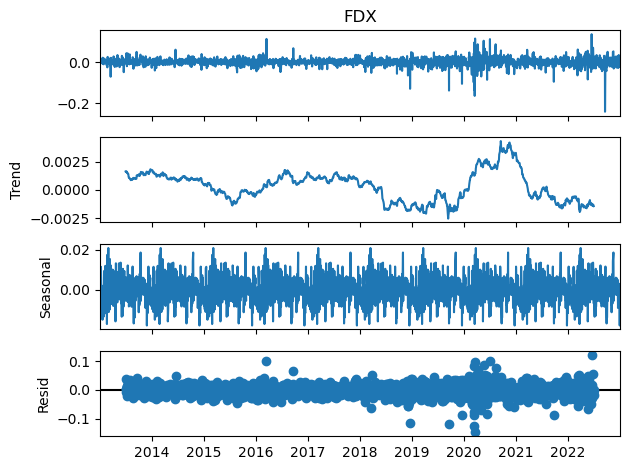

------------------------
Are the Residuals a WN ?
------------------------
Residuals is a WN


,initial,trend,seasonal,residuals
2013-01-02,0.027210,NaN,-0.000018,NaN
2013-01-03,0.003706,NaN,-0.009560,NaN
2013-01-04,0.003272,NaN,0.001452,NaN
2013-01-07,-0.002004,NaN,-0.002930,NaN
2013-01-08,0.004109,NaN,-0.000847,NaN
...,...,...,...,...
2022-12-23,0.001365,NaN,-0.000371,NaN
2022-12-27,0.006346,NaN,-0.001843,NaN
2022-12-28,-0.022852,NaN,-0.017581,NaN
2022-12-29,0.014343,NaN,-0.001637,NaN


In [19]:
serie_decompositon(df_series_log_diff["FDX"])

#### Decomposition of FedEx stock market time series (after first difference)

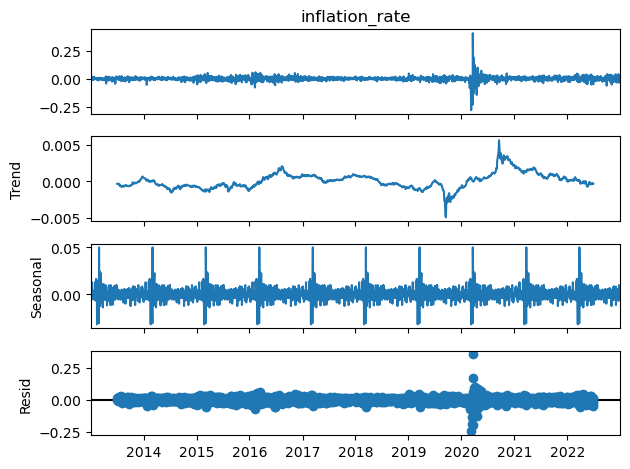

------------------------
Are the Residuals a WN ?
------------------------
Residuals is a WN


,initial,trend,seasonal,residuals
2013-01-02,0.012171,NaN,0.000993,NaN
2013-01-03,-0.008097,NaN,-0.000789,NaN
2013-01-04,0.008097,NaN,-0.000874,NaN
2013-01-07,0.016000,NaN,-0.006054,NaN
2013-01-08,-0.011976,NaN,0.002768,NaN
...,...,...,...,...
2022-12-23,0.004556,NaN,0.009487,NaN
2022-12-27,0.026907,NaN,-0.000453,NaN
2022-12-28,0.008811,NaN,-0.000424,NaN
2022-12-29,-0.004396,NaN,0.000611,NaN


In [20]:
serie_decompositon(df_series_log_diff["inflation_rate"])

#### Decomposition of Inflation Rate time series

According to the decomposition of the each time series we can see that our first difference seems to have no trend and no seasonality

### Using ACF and PACF to choose model order

By comparing the ACF and PACF for a time series, we can deduce the order of the model. If the amplitude of the ACF decreases with increasing lag and the PACF cuts off after a certain lag p, then we have an AR(p) model.

If the ACF amplitude cuts off after a certain offset q and the PACF amplitude decreases, then we have an MA(q) model.

In summary:

**AR(p)**
* ACF -> Tails off
* PACG -> Cuts off after lag p

**MA(q)**
* ACF -> Cuts off after lag q
* PACF -> Tails off

**ARMA(p,q)**
* Tails off
* Tails off

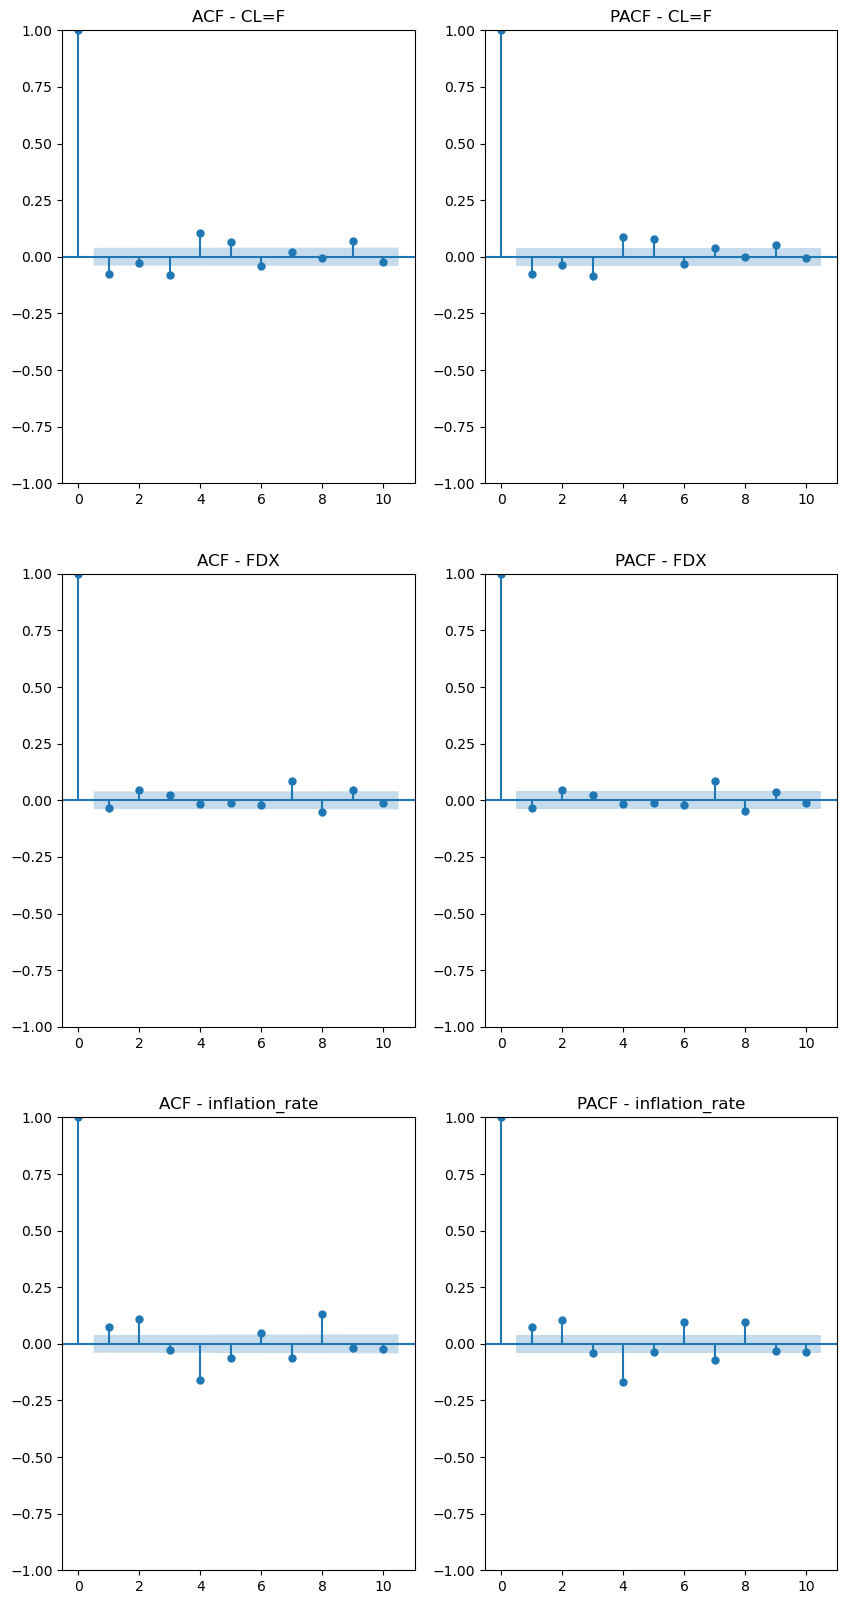

In [21]:
# Plot ACF and PACF for each time series
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 20))

for i, col in enumerate(df_series_log_diff.columns):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]

    # Plot ACF
    plot_acf(df_series_log_diff[col], lags=10, ax=ax1)
    ax1.set_title(f'ACF - {col}')
    
    plot_pacf(df_series_log_diff[col], lags=10, ax=ax2)
    ax2.set_title(f'PACF - {col}')

According to the PACF and ACF plots, we can see that for Oil stock prices (CL=F):
* ACF cuts off after lag 1
* PACF cuts off after lag 1

Hence, the best order seems to be $P=1$ and $Q=1$

According to the PACF and ACF plots, we can see that for Oil stock prices (FDX):
* ACF cuts off after lag 2
* PACF cuts off after lag 2

Hence, the best order seems to be $P=2$ and $Q=2$

According to the PACF and ACF plots, we can see that for Oil stock prices (FDX):
* ACF cuts off after lag 2
* PACF cuts off after lag 2

Hence, the best order seems to be $P=2$ and $Q=2$

Let's verify that with AIC and BIC criterion

### Searching best parameters for ARMA model over AIC and BIC criterion

In [42]:
def select_order_arima(serie):
    order_criteria = list()

    # Loop over AR order
    for p in range(3):
        # Loop over MA order
        for q in range(3):
            # Fit model
            model = ARIMA(serie, order=(p, 1, q))
            results = model.fit()
            
            # Calculate AIC, BIC, MSE, and RMSE
            aic = results.aic
            bic = results.bic
            residuals = results.resid
            mse = (residuals ** 2).mean()
            rmse = mse ** 0.5
            
            order_criteria.append((p, q, aic, bic, mse, rmse))

    # Create a DataFrame from the list
    df = pd.DataFrame(order_criteria, columns=['p', 'q', 'AIC', 'BIC', 'MSE', 'RMSE'])
    
    # Sort the DataFrame by AIC, BIC, MSE, or RMSE in ascending or descending order
    df = df.sort_values(by=['AIC', 'BIC', 'MSE', 'RMSE'], ascending=[True, True, True, True])
    
    return df

In [43]:
print("###########################################")
print("ARIMA for Oil stock prices")
print("###########################################\n")
select_order_arima(df_series_log_diff["CL=F"])

###########################################
ARIMA for Oil stock prices
###########################################



,p,q,AIC,BIC,MSE,RMSE
8,2,2,-10268.548119,-10239.431891,0.000954,0.030882
2,0,2,-10267.506151,-10250.036414,0.000956,0.030914
7,2,1,-10267.263245,-10243.970263,0.000955,0.030903
4,1,1,-10266.253639,-10248.783902,0.000956,0.030922
5,1,2,-10255.177816,-10231.884834,0.000959,0.030975
1,0,1,-10253.086260,-10241.439768,0.000962,0.031017
6,2,0,-9391.364660,-9373.894923,0.001360,0.036877
3,1,0,-9138.933885,-9127.287393,0.001506,0.038805
0,0,0,-8343.796716,-8337.973470,0.002072,0.045519


According to AIC, BIC, MSE and MSE criterions, The best order for a ARMA model are $P=2$ and $Q=2$

In [44]:
print("###########################################")
print("ARIMA for FedEx stock prices")
print("###########################################\n")
select_order_arima(df_series_log_diff["FDX"])

###########################################
ARIMA for FedEx stock prices
###########################################



,p,q,AIC,BIC,MSE,RMSE
7,2,1,-12583.977992,-12560.685009,0.000378,0.019452
4,1,1,-12580.654751,-12563.185014,0.000379,0.019473
2,0,2,-12580.437334,-12562.967597,0.000379,0.019474
1,0,1,-12580.108127,-12568.461635,0.000380,0.019483
8,2,2,-12578.686701,-12549.570473,0.000379,0.019464
5,1,2,-12576.973223,-12553.680240,0.000379,0.019479
6,2,0,-11930.968227,-11913.498490,0.000492,0.022189
3,1,0,-11632.845572,-11621.199081,0.000555,0.023562
0,0,0,-10781.086915,-10775.263669,0.000781,0.027951


According to AIC and MSE criterions, the best order for a ARMA model are $P=2$ and $Q=1$.

Let's fit a ARMA(2,1,1) for the FedEx stock prices serie

In [45]:
print("###########################################")
print("ARIMA for Inflation Rate")
print("###########################################\n")
select_order_arima(df_series_log_diff["inflation_rate"])

###########################################
ARIMA for Inflation Rate
###########################################



,p,q,AIC,BIC,MSE,RMSE
7,2,1,-12394.890124,-12371.597142,0.000408,0.020194
8,2,2,-12381.557887,-12352.441658,0.000410,0.020240
4,1,1,-12368.862072,-12351.392335,0.000412,0.020306
2,0,2,-12366.430772,-12348.961035,0.000413,0.020316
5,1,2,-12358.037302,-12334.744319,0.000414,0.020342
1,0,1,-12357.341482,-12345.694990,0.000415,0.020361
6,2,0,-11759.106769,-11741.637032,0.000527,0.022959
3,1,0,-11610.914360,-11599.267869,0.000560,0.023660
0,0,0,-10826.035439,-10820.212194,0.000767,0.027697


According to BIC and AIC criterions, The best order for a ARMA model are $P=2$ and $Q=1$

Let's fit a ARMA(2,1,1) for the Inflation Rate serie

### Check the residuals of the ARMA

Finally check that the residuals of the ARMA you retain are not serially
correlated. To do so we will perform an ACF and Liung-Box-test and plot different graphics such as Normal Q-Q, Histogram + estimated density and correlogram

**Residuals plot**

This plot shows the standardized residuals. If our model works correctly, there should be no obvious structure in the residuals.

**Histogram + estimated density**

The histogram shows the distribution of residuals.

**Normal Q-Q**

The normal QQ diagram is another way of showing how the distribution of model residuals compares to a normal distribution. If our residuals are normally distributed, all points should lie along the line.

**Correlogram**

The final graph is the correlogram, which is simply an ACF graph of the residuals rather than the data. 95% of correlations for a shift greater than zero should not be significant. If there is a significant correlation in the residuals, it means that there is information in the data that our model has not captured.

In summary:
- Standardized residual: There are no obvious pattern in the residuals
- Histogram + KDE estimate: The KDE curve should be very similar to the normal distribution
- Normal Q-Q: Most of the data points should be lie on the straight line
- Correlogram: 95% of correlations for lag grater than zero should be significant

**Ljung-Box test**

* $H_0$: The residuals are independently distributed.There is no serial correlation in the time series up to a certain lag

* $H_1$: The residuals are not independently distributed; they exhibit serial correlation.

In [51]:
def check_corr_resid(serie, order):
    # Fit an ARMA(1,1) model
    model = ARIMA(serie, order=order)
    results = model.fit()

    # Get the residuals
    residuals = results.resid

    # Print the mean of the residuals
    mean_residuals = np.mean(residuals)
    print(f"Mean of Residuals: {mean_residuals}")

    # Perform the Ljung-Box test
    df = acorr_ljungbox(residuals, lags=3, return_df=True)
    
    if any(df["lb_pvalue"]<0.05):
        print("We reject H0 and accept H1:The residuals are not independently distributed")
        print("Serial correlation detected in residuals.")
    else:
        print("We fail to reject H0: The residuals are independently distributed.")
        print("No significant serial correlation in residuals.")
        
    results.plot_diagnostics()
    plt.show()
    
    return df

#### Check residuals of the ARMA for Oil stock prices

Mean of Residuals: 0.00024320361812085295
We reject H0 and accept H1:The residuals are not independently distributed
Serial correlation detected in residuals.


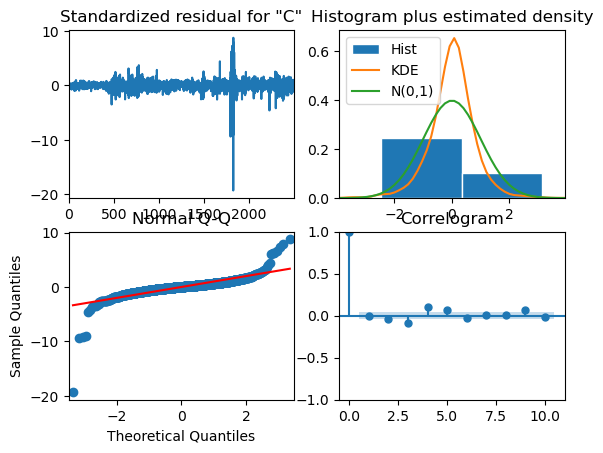

,lb_stat,lb_pvalue
1,0.021629,0.883078
2,3.502415,0.173564
3,19.882686,0.000180


In [52]:
check_corr_resid(df_series_log_diff["CL=F"], (2,1,2))

#### Check residuals of the ARMA for FedEx stock prices

Mean of Residuals: -0.00048308230303752814
We fail to reject H0: The residuals are independently distributed.
No significant serial correlation in residuals.


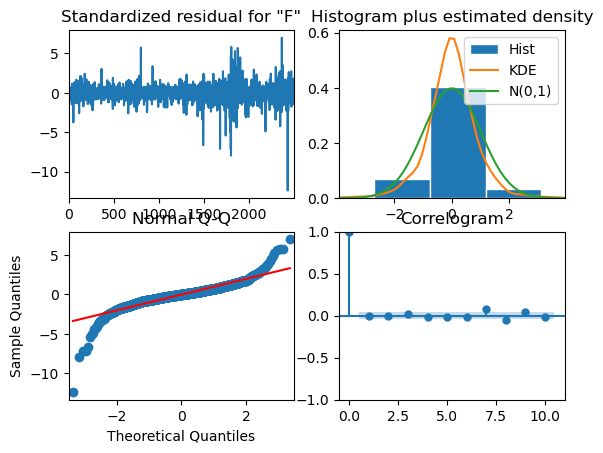

,lb_stat,lb_pvalue
1,0.010331,0.919042
2,0.011835,0.994100
3,1.406640,0.703979


In [53]:
check_corr_resid(df_series_log_diff["FDX"], (2,1,1))

#### Check residuals of the ARMA for Inflation Rates

Mean of Residuals: 0.00016226042700602015
We fail to reject H0: The residuals are independently distributed.
No significant serial correlation in residuals.


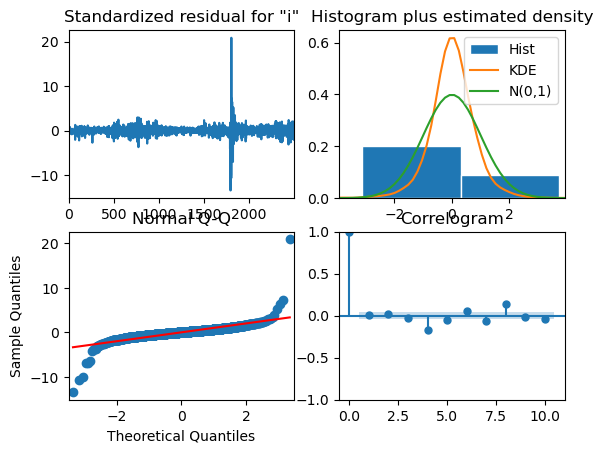

,lb_stat,lb_pvalue
1,0.033711,0.854323
2,1.102634,0.576190
3,2.802910,0.423021


In [54]:
check_corr_resid(df_series_log_diff["inflation_rate"], (2,1,1))

We can draw the same conclusion for our 3 series.

The Q-Q plot of each series looks like a Heavy tailed q-q plot. This means that, compared with the normal distribution, there is much more data in the extremities than in the center of the distribution.

Furthermore, according to the density histogram, we can see that the green line showing a normal distribution is far from the KDE distribution (i.e. orange line. 

This suggests that our ARIMA model can be improved.